In [1]:
import os
import subprocess
import sys
import numpy as np
from IPython.display import display, HTML
import itertools
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2

In [2]:
from GenModels.GM.States.GraphicalMessagePassing import DataGraph, \
                                                        GraphHMMFBS
from GenModels.GM.Distributions import Categorical, Dirichlet

# Make the graph

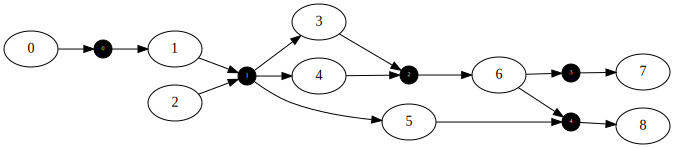

In [3]:
# Latent state size of 3 so that we can use rgb values to interpret them
d_latent     = 3
d_obs        = 2

# This is the number of times we measure an emission from the same 
# latent state for a node
measurements = 3

graph = DataGraph()
graph.addEdge( parents=[ 0 ], children=[ 1 ] )
graph.addEdge( parents=[ 1, 2 ], children=[ 3, 4, 5 ] )
graph.addEdge( parents=[ 3, 4 ], children=[ 6 ] )
graph.addEdge( parents=[ 6 ], children=[ 7 ] )
graph.addEdge( parents=[ 5, 6 ], children=[ 8 ] )

# Add random data that is either 0 or 1
for node in graph.nodes:
    data = Categorical.generate( D=d_obs, size=measurements )
    graph.setNodeData( node, data )

# Add prior knowledge about the latent states
graph.setPossibleLatentStates( 5, [ 0, 1 ] )
graph.setPossibleLatentStates( 1, [ 1, 2 ] )

feedback_set = np.array( [ 3, 5 ] )
graph.draw( horizontal=True )

# Make the model

In [4]:
# Initial dist
initial_dists = Dirichlet.generate( D=d_latent )

# Check how many transition distributions we need
all_transition_counts = set()
for parents in graph.edge_parents:
    ndim = len( parents ) + 1
    all_transition_counts.add( ndim )

# Create the transition distribution
transition_dists = []
for ndim in all_transition_counts:
    shape = [ d_latent for _ in range( ndim ) ]
    trans = np.empty( shape )
    for indices in itertools.product( *[ range( s ) for s in shape[ 1: ] ] ):
        trans[ indices ] = Dirichlet.generate( D=d_latent )

    transition_dists.append( trans )

# Emission dist
emission_dist = Dirichlet.generate( D=d_obs, size=d_latent )

# Create the message passer and initialize
msg = GraphHMMFBS()
msg.updateParams( initial_dists, transition_dists, emission_dist, [ ( graph, feedback_set ) ] )

# Filter

In [5]:
U, V = msg.filter()

# The smoothed probabilities agree with the known latent states

In [6]:
for n, probs in msg.nodeSmoothed( U, V, msg.nodes ):
    print( 'P( x_%d | Y )'%( n ), ':', np.exp( probs ) )

P( x_0 | Y ) : [0.53179279 0.00074839 0.46745883]
P( x_1 | Y ) : [0.         0.03198773 0.96801227]
P( x_2 | Y ) : [0.27417336 0.0085117  0.71731495]
P( x_3 | Y ) : [0.72699976 0.00247621 0.27052403]
P( x_4 | Y ) : [0.65030754 0.05323824 0.29645422]
P( x_5 | Y ) : [0.75491668 0.24508332 0.        ]
P( x_6 | Y ) : [0.90808275 0.07348114 0.01843612]
P( x_7 | Y ) : [0.78191241 0.02176523 0.19632236]
P( x_8 | Y ) : [0.85266499 0.03928522 0.10804979]
